# MUSA 6500 Homework 3: Supervised Land Use Classification with Google Earth Engine

In this assignment, you will use Google Earth Engine via Python to implement multi-class land cover classification. You will hand-label Landsat 8 satellite images which you will then use to train a random forest model. Along the way, you will consider practical remote sensing issues like cloud cover, class imbalances, and feature selection.

**Given that hand-labeling data can be time-consuming, you are encouraged to work in pairs or groups of three to share the workload. You may collaborate on generating the hand-labeled data, provided you submit separate assignment files. If you choose to do this, you should all use the same ROI, of course.**

You are responsible for figuring out the code independently and may refer to tutorials, code examples, or use AI support, but **please cite all sources**.

In particular, we encourage you to consult the [official Python Google Earth Engine `geemap` package](https://geemap.org/), the online course [Spatial Thoughts](https://spatialthoughts.com/courses/google-earth-engine/), and the [Google Earth Engine Tutorials book](https://google-earth-engine.com/).

Submit a single Jupyter Notebook containing code, narrative text, visualizations, and answers to each question. Please also upload your classification results as a GeoTIFF and your accuracy assessment as a CSV file. Open a pull request from your fork of this repository to the main repository for submission.

## 1. Setup

For this assignment, you will define the region of interest (ROI) of your choice. We recommend picking an urban area large enough that you will have a sufficient sample size but not so large that it will take an excessively long time to process.

You'll also use Landsat 8 satellite imagery from USGS for this assignment. Choose images from 2023, filtering for images with minimal cloud cover.

In [1]:
# Load all necessary libraries
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd

# The following are colab-specific
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ee.Authenticate()
ee.Initialize(project='musa-6500-spring-2025')

In [3]:
# Region of Interest: Seattle
seattle_bbox = ee.Geometry.Rectangle([-122.435, 47.495, -122.225, 47.735])

# Define a small buffer to ensure we do not miss Seattle
seattle_buffered = seattle_bbox.buffer(2000)

# Apply scaling factors (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
def apply_scale_factors(image):
  opticalBands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
  return image.addBands(opticalBands, None, True)

# Load Landsat 8 Collection
# Pull the image for the least cloudy day in 2023
seattle_landsat = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
           .filterDate("2023-01-01", "2023-12-31")                        # Filter for 2023
           .filterBounds(seattle_bbox)                                    # Filter for Seattle
           .map(apply_scale_factors)                                      # Apply scaling factors
           .sort("CLOUD_COVER")                                           # Sort by cloud cover percentage in ascending order
           .first()                                                       # Select the least cloudy image
           .clip(seattle_bbox))                                           # Clip the image to Seattle

seattle_landsat_export = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
           .filterDate("2023-01-01", "2023-12-31")                        # Filter for 2023
           .filterBounds(seattle_bbox)                                    # Filter for Seattle
           .map(apply_scale_factors)                                      # Apply scaling factors
           .sort("CLOUD_COVER")                                           # Sort by cloud cover percentage in ascending order
           .first()                                                       # Select the least cloudy image
           .clip(seattle_buffered))                                       # Clip the image to the buffered Seattle zone

In [4]:
# Check the date which the landsat image is pulled from
print("For the current execution, the image date is:", ee.Date(seattle_landsat.get("system:time_start")).format("YYYY-MM-dd").getInfo())
print("For the current execution, the image date is:", ee.Date(seattle_landsat_export.get("system:time_start")).format("YYYY-MM-dd").getInfo())

For the current execution, the image date is: 2023-08-16
For the current execution, the image date is: 2023-08-16


**<u>Remark:</u>** The image that is used for labeling is actually from April 10, 2023 ("2023-04-10"), but somehow when I re-run the codes it gives me an image from August instead.

In [ ]:
# Export Landsat (True Color Image 432)
# Reduce the resolution to reduce file size
geemap.ee_export_image(seattle_landsat_export, scale=60, filename="/content/drive/MyDrive/landsat_seattle_2023_v3.tif", region=seattle_buffered)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/landsat_seattle_2023_v3.tif


In [5]:
# Visualization Settings for Seattle image (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
visualization = {
  "bands": ["SR_B4", "SR_B3", "SR_B2"],  # True color (red, green, blue)
  "min": 0.0,
  "max": 0.3
}

In [6]:
# Create Map for visualization (Obtained from https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=zh-tw#colab-python)
Map = geemap.Map()
Map.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

## 2. Data Collection and Feature Engineering

### 2.1 Collecting and Labeling Training Data

Using the [interactive `geemap` intereface](https://www.youtube.com/watch?v=VWh5PxXPZw0) or another approach (e.g., QGIS, ArcGIS, a GeoJSON file, etc.), create at least 100 samples (points or polygons) for each of the following four classes: urban, bare, water, and vegetation. (Again, we encourage you to work in pairs or groups of three to generate these hand labels.) Use visual cues and manual inspection to ensure that the samples are accurate. Assign each class a unique label (e.g., 0 for urban, 1 for bare, 2 for water, and 3 for vegetation) and merge the labeled samples into a single dataset. You are free to propose any labels you like, as long as 1) you include at least 4 classes, and 2) you justify why they are appropriate for a remote sensing task (for example, including a label for ice cream shops wouldn't make sense, because those can't be detected from aerial imagery).

In [ ]:
# The following codes are used to convert the type of "id" into a string so that subsequent geemap-related functions will execute without issues
import json

# Load the GeoJSON file
with open("/content/drive/MyDrive/labels_0743.geojson", "r") as f:
    geojson_data = json.load(f)

# Convert "id" to a string for all features
for feature in geojson_data["features"]:
    feature["id"] = str(feature["id"])  # Convert 'id' to string

# Save the modified GeoJSON back
with open("/content/drive/MyDrive/labels_0743_updated.geojson", "w") as f:
    json.dump(geojson_data, f)

print("GeoJSON has been updated with string IDs!")

In [7]:
labels = geemap.geojson_to_ee("/content/drive/MyDrive/labels_0743_updated.geojson")

In [8]:
labels.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-122.41904166799998, 47.67268282100008]},
 'id': '1',
 'properties': {'OBJECTID': 1, 'OBJECTID_1': 52, 'Typology': 'W'}}

### 2.2 Feature Engineering.

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)

Additionally, add elevation and slope data from a DEM. Normalize all image bands to a 0 to 1 scale for consistent model input.

For bonus points, consider adding [kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) (e.g., edge detection, smoothing) to see if they improve model performance.

In [9]:
# Split the data into separate collections based on the "Typology" property
urban = labels.filter(ee.Filter.eq("Typology", "U"))
bare = labels.filter(ee.Filter.eq("Typology", "B"))
water = labels.filter(ee.Filter.eq("Typology", "W"))
vegetation = labels.filter(ee.Filter.eq("Typology", "V"))

# Merge all labeled samples into a single dataset
sample = urban.merge(bare).merge(water).merge(vegetation)

# Define a dictionary mapping "Typology" to numeric labels
label_map = ee.Dictionary({
    "U": 0, # Urban
    "B": 1, # Bare
    "W": 2, # Water
    "V": 3  # Vegetation
})

# Function to assign numeric labels based on "Typology"
def label_to_numeric(feature):
    return feature.set("Landcover", label_map.get(feature.get("Typology")))

# Apply the function to the training data
sample = sample.map(label_to_numeric)

# Check the property names of the first feature to ensure 'landcover' was added
print(sample.first().propertyNames().getInfo())

['Landcover', 'system:index', 'OBJECTID', 'OBJECTID_1', 'Typology']


In [10]:
# NDVI (Normalized Difference Vegetation Index)
ndvi = seattle_landsat_export.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")

# NDBI (Normalized Difference Built-up Index)
ndbi = seattle_landsat_export.normalizedDifference(["SR_B6", "SR_B5"]).rename("NDBI")

# MNDWI (Modified Normalized Difference Water Index)
mndwi = seattle_landsat_export.normalizedDifference(["SR_B3", "SR_B7"]).rename("MNDWI")

# Add indices to the image
seattle_landsat_export = seattle_landsat_export.addBands([ndvi, ndbi, mndwi])

In [11]:
# Load SRTM DEM
dem = ee.Image("USGS/SRTMGL1_003").clip(seattle_buffered)
slope = ee.Terrain.slope(dem)

# Add elevation and slope bands to the image
seattle_landsat_export = seattle_landsat_export.addBands(dem.rename("Elevation"))
seattle_landsat_export = seattle_landsat_export.addBands(slope.rename("Slope"))

In [12]:
def normalize(image, band):
    min_max = image.reduceRegion(ee.Reducer.minMax(), seattle_buffered, 30, bestEffort = True)
    min_val = ee.Number(min_max.get(f"{band}_min"))
    max_val = ee.Number(min_max.get(f"{band}_max"))
    normalized = image.select(band).subtract(min_val).divide(max_val.subtract(min_val)).rename(f"{band}_norm")
    return normalized.updateMask(normalized.gt(0).And(normalized.lte(1)))  # Mask out invalid values

bands_to_normalize = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "NDVI", "NDBI", "MNDWI", "Elevation", "Slope"]
normalized_bands = [normalize(seattle_landsat_export, band) for band in bands_to_normalize]

# Combine all features
final_image = ee.Image.cat(normalized_bands)

In [13]:
# Sobel filter (Edge Detection)
sobel_kernel = ee.Kernel.sobel()
sobel_image = final_image.convolve(sobel_kernel).rename(
    final_image.bandNames().map(lambda name: ee.String(name).cat("_sobel"))
)

# Gaussian smoothing filter
gaussian_kernel = ee.Kernel.gaussian(radius=3, sigma=1.0, units="pixels")
smooth_image = final_image.convolve(gaussian_kernel).rename(
    final_image.bandNames().map(lambda name: ee.String(name).cat("_smooth"))
)

# Combine original normalized bands with filtered bands
final_image_with_filters = final_image.addBands(sobel_image).addBands(smooth_image)

In [14]:
Map2 = geemap.Map()
Map2.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map2.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm"), {"min": 0, "max": 1}, "Normalized Red Band")
Map2.addLayer(final_image_with_filters.select("NDVI_norm"), {"min": 0, "max": 1}, "Normalized NDVI")
Map2.addLayer(final_image_with_filters.select("Elevation_norm"), {"min": 0, "max": 1}, "Normalized Elevation")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm_sobel"), {"min": -1, "max": 1}, "Red Band Edge")
Map2.addLayer(final_image_with_filters.select("SR_B4_norm_smooth"), {"min": -1, "max": 1}, "Red Band Smooth")

Map2  # Display the map

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [15]:
# Combine NDVI, NDBI, MNDWI, Slope, and elevation to samples
sample = final_image_with_filters.sampleRegions(
    collection = sample,
    properties = ["Landcover"],
    scale = 30,
    geometries = True
)

# Check that features were added
sample.first().getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Point',
  'coordinates': [-122.38284136180354, 47.636099752488455]},
 'id': '1_1_1_152_0',
 'properties': {'Elevation_norm': 0.17224881052970886,
  'Elevation_norm_smooth': 0.1698793946705717,
  'Elevation_norm_sobel': -0.0382775217294693,
  'Landcover': 0,
  'MNDWI_norm': 0.670789207520759,
  'MNDWI_norm_smooth': 0.6322656177288455,
  'MNDWI_norm_sobel': 0.01567920787443089,
  'NDBI_norm': 0.45903316577719816,
  'NDBI_norm_smooth': 0.46955481773286356,
  'NDBI_norm_sobel': -0.04114848566964491,
  'NDVI_norm': 0.5162980536111927,
  'NDVI_norm_smooth': 0.5176537542522495,
  'NDVI_norm_sobel': 0.03277581587798606,
  'SR_B1_norm': 0.7582563625490066,
  'SR_B1_norm_smooth': 0.62933798746589,
  'SR_B1_norm_sobel': 0.41434646820386734,
  'SR_B2_norm': 0.764887225140772,
  'SR_B2_norm_smooth': 0.6290026360277852,
  'SR_B2_norm_sobel': 0.4522004466953974,
  'SR_B3_norm': 0.7543748752412004,
  'SR_B3_norm_smooth': 0.597278402445321

## 3. Model Training and Evaluation

### 3.1 Model Training

Split your data into a training dataset (70%) and a validation dataset (30%). Train and evaluate a random forest model using the training set with all engineered features.

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion. Identify which features are most influential in the classification. Report the final features that you keep in your model.

In [16]:
# Train-test split (70/30)
seed_value = 42

# Split
sample = sample.randomColumn("split", seed_value)
sample_train = sample.filter(ee.Filter.lt("split", 0.7))
sample_test = sample.filter(ee.Filter.gte("split", 0.7))

Model 1: Using normalized bands, NDVI, NDBI, MNDWI, elevation, and slope as features.

In [17]:
features = [
    'SR_B1_norm', 'SR_B2_norm', 'SR_B3_norm', 'SR_B4_norm',
    'SR_B5_norm', 'SR_B6_norm', 'SR_B7_norm',
    'NDVI_norm', 'NDBI_norm', 'MNDWI_norm',
    'Elevation_norm', 'Slope_norm'
]

# Random forest model 1
model1 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features
)

# Variable importance scores
importance_model1 = model1.explain().get("importance")
importance_scores_model1 = importance_model1.getInfo()

importance_model1_df = pd.DataFrame(list(importance_scores_model1.items()), columns = ["Feature", "Importance Score"])
importance_model1_df = importance_model1_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model1_df.to_string(index = False))

       Feature  Importance Score
     NDVI_norm         30.560129
    SR_B1_norm         27.077881
    MNDWI_norm         25.491253
    SR_B3_norm         25.420425
    SR_B4_norm         24.573583
    SR_B7_norm         23.423418
     NDBI_norm         23.049553
    SR_B2_norm         21.455914
    SR_B6_norm         21.098664
Elevation_norm         20.890799
    SR_B5_norm         20.522337
    Slope_norm         17.993611


Based on the variable importance scores, I decided to drop all features with an importance score below 23, i.e., I am retaining "NDVI_norm", "SR_B1_norm", "MNDWI_norm", "SR_B3_norm", "SR_B4_norm", "SR_B7_norm", and "NDBI_norm" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm", "SR_B3_norm", "SR_B4_norm")
*   Water ("MNDWI_norm", "SR_B1_norm")
*   Urban/Built-up areas ("NDBI_norm", "SR_B7_norm")

In [18]:
# Refined model 1
features_refined = [
    'NDVI_norm', 'SR_B1_norm', 'MNDWI_norm',
    'SR_B3_norm', 'SR_B4_norm', 'SR_B7_norm', 'NDBI_norm'
]

# Random forest model 1
model1_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_refined
)

# Variable importance scores
importance_model1_refined = model1_refined.explain().get("importance")
importance_scores_model1_refined = importance_model1_refined.getInfo()

importance_model1_refined_df = pd.DataFrame(list(importance_scores_model1_refined.items()), columns = ["Feature", "Importance Score"])
importance_model1_refined_df = importance_model1_refined_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model1_refined_df.to_string(index = False))

   Feature  Importance Score
 NDVI_norm         52.916254
MNDWI_norm         49.965854
SR_B3_norm         47.709616
 NDBI_norm         45.369480
SR_B4_norm         43.656295
SR_B1_norm         43.149591
SR_B7_norm         37.388739


Model 2: Using normalized and smoothed bands, NDVI, NDBI, MNDWI, elevation, and slope as features.

In [19]:
features_m2 = [
    'SR_B1_norm_smooth', 'SR_B2_norm_smooth', 'SR_B3_norm_smooth', 'SR_B4_norm_smooth',
    'SR_B5_norm_smooth', 'SR_B6_norm_smooth', 'SR_B7_norm_smooth',
    'NDVI_norm_smooth', 'NDBI_norm_smooth', 'MNDWI_norm_smooth',
    'Elevation_norm_smooth', 'Slope_norm_smooth'
]

# Random forest model 2
model2 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m2
)

# Variable importance scores
importance_model2 = model2.explain().get("importance")
importance_scores_model2 = importance_model2.getInfo()

importance_model2_df = pd.DataFrame(list(importance_scores_model2.items()), columns = ["Feature", "Importance Score"])
importance_model2_df = importance_model2_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model2_df.to_string(index = False))

              Feature  Importance Score
    SR_B1_norm_smooth         23.795708
    MNDWI_norm_smooth         23.777712
    SR_B7_norm_smooth         22.556238
    SR_B3_norm_smooth         21.531813
     NDVI_norm_smooth         20.236536
     NDBI_norm_smooth         20.116521
    SR_B2_norm_smooth         19.962764
    SR_B4_norm_smooth         19.920819
Elevation_norm_smooth         18.656483
    SR_B5_norm_smooth         17.190923
    SR_B6_norm_smooth         12.797182
    Slope_norm_smooth         11.865869


Based on the variable importance scores, I decided to drop all features with an importance score below 20, i.e., I am retaining "SR_B1_norm_smooth", "MNDWI_norm_smooth", "SR_B7_norm_smooth", "SR_B3_norm_smooth", "NDVI_norm_smooth", and "NDBI_norm_smooth" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm_smooth", "SR_B3_norm_smooth")
*   Water ("MNDWI_norm_smooth", "SR_B1_norm_smooth")
*   Urban/Built-up areas ("NDBI_norm_smooth", "SR_B7_norm_smooth")

In [20]:
# Refined model 2
features_m2_refined = [
    'SR_B1_norm_smooth', 'MNDWI_norm_smooth', 'SR_B7_norm_smooth',
    'SR_B3_norm_smooth', 'NDVI_norm_smooth', 'NDBI_norm_smooth'
]

# Random forest model 2
model2_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m2_refined
)

# Variable importance scores
importance_model2_refined = model2_refined.explain().get("importance")
importance_scores_model2_refined = importance_model2_refined.getInfo()

importance_model2_refined_df = pd.DataFrame(list(importance_scores_model2_refined.items()), columns = ["Feature", "Importance Score"])
importance_model2_refined_df = importance_model2_refined_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model2_refined_df.to_string(index = False))

          Feature  Importance Score
MNDWI_norm_smooth         46.387211
SR_B1_norm_smooth         44.868181
SR_B3_norm_smooth         40.680898
 NDBI_norm_smooth         39.119938
SR_B7_norm_smooth         35.083787
 NDVI_norm_smooth         34.490383


Model 3: Using normalized bands, NDVI, NDBI, MNDWI, elevation, and slope with edge detection (using the Sobel kernel) as features.

In [26]:
features_m3 = [
    'SR_B1_norm_sobel', 'SR_B2_norm_sobel', 'SR_B3_norm_sobel', 'SR_B4_norm_sobel',
    'SR_B5_norm_sobel', 'SR_B6_norm_sobel', 'SR_B7_norm_sobel',
    'NDVI_norm_sobel', 'NDBI_norm_sobel', 'MNDWI_norm_sobel',
    'Elevation_norm_sobel', 'Slope_norm_sobel'
]

# Random forest model 3
model3 = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m3
)

# Variable importance scores
importance_model3 = model3.explain().get("importance")
importance_scores_model3 = importance_model3.getInfo()

importance_model3_df = pd.DataFrame(list(importance_scores_model3.items()), columns = ["Feature", "Importance Score"])
importance_model3_df = importance_model3_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model3_df.to_string(index = False))

             Feature  Importance Score
    SR_B1_norm_sobel         66.506976
     NDVI_norm_sobel         66.225873
     NDBI_norm_sobel         60.946285
Elevation_norm_sobel         59.103016
    Slope_norm_sobel         58.895630
    SR_B2_norm_sobel         57.682689
    MNDWI_norm_sobel         57.382463
    SR_B4_norm_sobel         56.561037
    SR_B5_norm_sobel         56.350918
    SR_B7_norm_sobel         53.757174
    SR_B3_norm_sobel         53.267538
    SR_B6_norm_sobel         53.165520


Based on the variable importance scores, I decided to drop all features with an importance score below 57, i.e., I am retaining "SR_B1_norm_sobel", "NDVI_norm_sobel", "NDBI_norm_sobel", "Elevation_norm_sobel", "Slope_norm_sobel", "SR_B2_norm_sobel", and "MNDWI_norm_sobel" as features.
Roughly speaking, the selected features capture diverse aspects of landcover classification:

*   Vegetation ("NDVI_norm_sobel")
*   Water ("MNDWI_norm_sobel", "SR_B1_norm_sobel")
*   Urban/Built-up areas ("NDBI_norm_sobel", "SR_B2_norm_sobel", "Elevation_norm_sobel", "Slope_norm_sobel")

In [31]:
# Refined model 3
features_m3_refined = [
    "SR_B1_norm_sobel", "NDVI_norm_sobel", "NDBI_norm_sobel",
    "Elevation_norm_sobel", "Slope_norm_sobel", "SR_B2_norm_sobel",
    "MNDWI_norm_sobel"
]

# Random forest model 3
model3_refined = ee.Classifier.smileRandomForest(100).train(
    features = sample_train,
    classProperty = "Landcover",
    inputProperties = features_m3_refined
)

# Variable importance scores
importance_model3_refined = model3_refined.explain().get("importance")
importance_scores_model3_refined = importance_model3_refined.getInfo()

importance_model3_refined_df = pd.DataFrame(list(importance_scores_model3_refined.items()), columns = ["Feature", "Importance Score"])
importance_model3_refined_df = importance_model3_refined_df.sort_values(by = "Importance Score", ascending = False)
print(importance_model3_refined_df.to_string(index = False))

             Feature  Importance Score
     NDVI_norm_sobel        124.637851
    SR_B1_norm_sobel        114.761303
    SR_B2_norm_sobel        110.289893
     NDBI_norm_sobel        110.009586
Elevation_norm_sobel        104.518664
    Slope_norm_sobel         97.033547
    MNDWI_norm_sobel         88.111649


### 3.2 Accuracy Assessment

Use the trained model to classify the Landsat 8 image, creating a land cover classification map with classes for urban, bare, water, and vegetation (or whatever classes you have chosen).

Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall. Which classes were confused most often with each other? Why do you think this was?

Visually compare your landcover data for your ROI with the corresponding [landcover data from the European Space Agency](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200). Do your classifications agree? If not, do you notice any patterns in the types of landcover where they differ, or any particular features in the imagery that are hard for your model to recognize (e.g., sand, water, or asphalt)?

Export the classified image as a GeoTIFF and the confusion matrix and accuracy metrics to a CSV file for documentation.

In [29]:
# Accuracy Assessment
# Apply the refined model 1 to Landsat 8 image
classified_m1 = final_image_with_filters.classify(model1_refined)

# Grey: Urban, Brown: Bare, Blue: Water, Green: Vegetation
Map3 = geemap.Map()
Map3.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map3.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map3.addLayer(classified_m1, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Land Cover Classification")
Map3

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [28]:
# Accuracy Assessment
# Apply the refined model 1 to Landsat 8 image
classified_m2 = final_image_with_filters.classify(model2_refined)

# Grey: Urban, Brown: Bare, Blue: Water, Green: Vegetation
Map4 = geemap.Map()
Map4.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map4.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map4.addLayer(classified_m2, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Land Cover Classification")
Map4

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

In [42]:
# Accuracy Assessment
# Apply the refined model 3 to Landsat 8 image
classified_m3 = final_image_with_filters.classify(model3_refined)

# Grey: Urban, Brown: Bare, Blue: Water, Green: Vegetation
Map5 = geemap.Map()
Map5.centerObject(seattle_landsat_export, 11)  # Zoom to Seattle
Map5.addLayer(seattle_landsat_export, visualization, "True Color (432)")
Map5.addLayer(classified_m3, {"min": 0, "max": 3, "palette": ["grey", "brown", "blue", "green"]}, "Land Cover Classification")
Map5

Map(center=[47.614952935580554, -122.33000000002237], controls=(WidgetControl(options=['position', 'transparen…

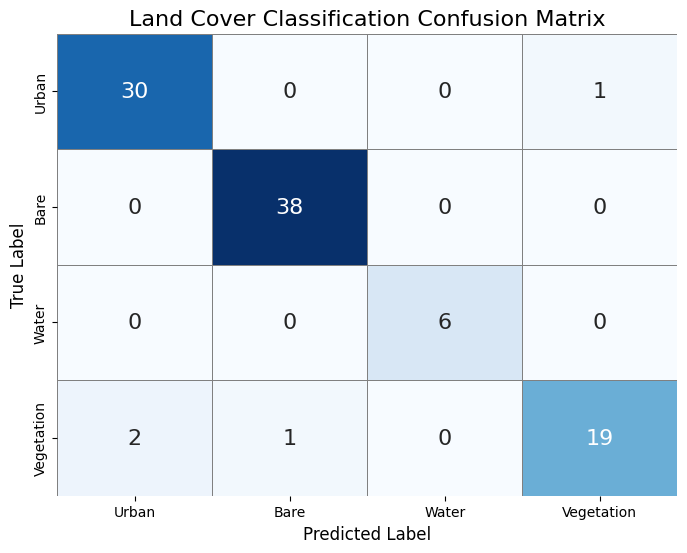

Overall Accuracy: 0.9903381642512077
     Class  Precision  Recall
     Urban     1.0000  0.9846
      Bare     0.9831  1.0000
     Water     1.0000  1.0000
Vegetation     0.9872  0.9872


In [44]:
# Evaluation metrics for the refined model 1
classified_testing_m1 = sample_test.classify(model1_refined)
conf_matrix_m1 = classified_testing_m1.errorMatrix("Landcover", "classification")
# conf_matrix_m1 = np.array(conf_matrix_m1)

labels = ['Urban', 'Bare', 'Water', 'Vegetation']
conf_matrix_m1_df = pd.DataFrame(conf_matrix_m1.getInfo(), index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m1_df, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, annot_kws = {"size": 16}, linewidths = 0.5, linecolor = 'gray')
plt.title("Land Cover Classification Confusion Matrix", fontsize = 16)
plt.ylabel('True Label', fontsize = 12)
plt.xlabel('Predicted Label', fontsize = 12)
plt.show()

overall_acc = confusion_matrix_m1.accuracy()
precision = confusion_matrix_m1.producersAccuracy()
recall = confusion_matrix_m1.consumersAccuracy()

# Convert results for better visualization
precision_values = precision.getInfo()
recall_values = recall.getInfo()

df_results = pd.DataFrame({
    "Class": labels,
    "Precision": [round(p[0], 4) for p in precision_values],
    "Recall": [round(r, 4) for r in recall_values[0]]
})

# Print overall accuracy
print("Overall Accuracy:", overall_acc.getInfo())

# Display the table
print(df_results.to_string(index=False))

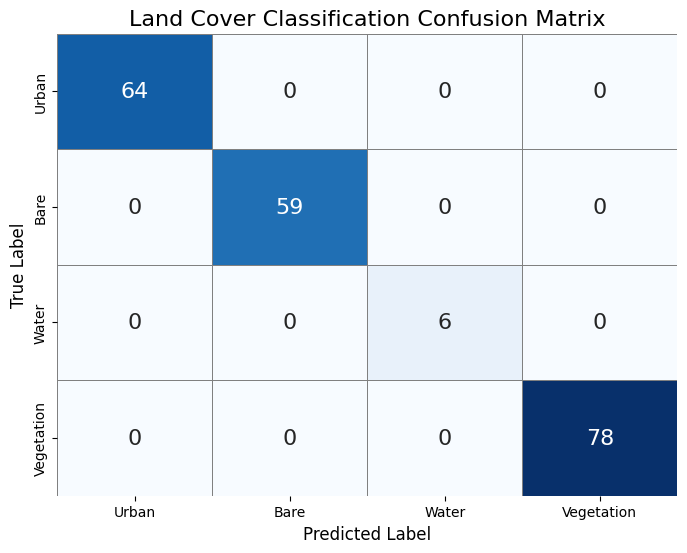

Overall Accuracy: 1
     Class  Precision  Recall
     Urban          1       1
      Bare          1       1
     Water          1       1
Vegetation          1       1


In [41]:
# Evaluation metrics for the refined model 2
conf_matrix_m2 = model2_refined.confusionMatrix().getInfo()
conf_matrix_m2 = np.array(conf_matrix_m2)

labels = ['Urban', 'Bare', 'Water', 'Vegetation']
conf_matrix_m2_df = pd.DataFrame(conf_matrix_m2, index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m2_df, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, annot_kws = {"size": 16}, linewidths = 0.5, linecolor = 'gray')
plt.title("Land Cover Classification Confusion Matrix", fontsize = 16)
plt.ylabel('True Label', fontsize = 12)
plt.xlabel('Predicted Label', fontsize = 12)
plt.show()

confusion_matrix_m2 = model2_refined.confusionMatrix()

overall_acc = confusion_matrix_m2.accuracy()
precision = confusion_matrix_m2.producersAccuracy()
recall = confusion_matrix_m2.consumersAccuracy()

# Convert results for better visualization
precision_values = precision.getInfo()
recall_values = recall.getInfo()

df_results = pd.DataFrame({
    "Class": labels,
    "Precision": [round(p[0], 4) for p in precision_values],
    "Recall": [round(r, 4) for r in recall_values[0]]
})

# Print overall accuracy
print("Overall Accuracy:", overall_acc.getInfo())

# Display the table
print(df_results.to_string(index=False))

In [ ]:
# Evaluation metrics for the refined model 3
conf_matrix_m3 = model3_refined.confusionMatrix().getInfo()
conf_matrix_m3 = np.array(conf_matrix_m3)

labels = ['Urban', 'Bare', 'Water', 'Vegetation']
conf_matrix_m3_df = pd.DataFrame(conf_matrix_m3, index = labels, columns = labels)

# Plot the heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_m3_df, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, annot_kws = {"size": 16}, linewidths = 0.5, linecolor = 'gray')
plt.title("Land Cover Classification Confusion Matrix", fontsize = 16)
plt.ylabel('True Label', fontsize = 12)
plt.xlabel('Predicted Label', fontsize = 12)
plt.show()

confusion_matrix_m3 = model3_refined.confusionMatrix()

overall_acc = confusion_matrix_m3.accuracy()
precision = confusion_matrix_m3.producersAccuracy()
recall = confusion_matrix_m3.consumersAccuracy()

# Convert results for better visualization
precision_values = precision.getInfo()
recall_values = recall.getInfo()

df_results = pd.DataFrame({
    "Class": labels,
    "Precision": [round(p[0], 4) for p in precision_values],
    "Recall": [round(r, 4) for r in recall_values[0]]
})

# Print overall accuracy
print("Overall Accuracy:", overall_acc.getInfo())

# Display the table
print(df_results.to_string(index=False))

## 4. Reflection Questions

What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?

What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?

Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).

Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?